# Visualize TorNet Classifications

This notebook loads a pretrained keras model and tests it on TorNet samples

In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # set to 'tensorflow', 'torch' or 'jax' (installs required)

In [2]:
import sys
# Uncomment if tornet isn't installed in your environment or in your path already
sys.path.append('../')  

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

from tornet.data.keras.loader import KerasDataLoader


2024-07-02 11:17:06.220506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 11:17:06.244967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 11:17:06.245004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 11:17:06.260937: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 11:17:08.916552: W tensorflow/compiler/tf

In [3]:
# Download the pretrained model for inference from huggingface
from huggingface_hub import hf_hub_download
model_file = hf_hub_download(repo_id="tornet-ml/tornado_detector_baseline_v1", 
                             filename="tornado_detector_baseline.keras")

# Alternatively, you can manually download the .keras file and put in the ../models/ directory
# https://huggingface.co/tornet-ml/tornado_detector_baseline_v1
#model_file = '../models/tornado_detector_baseline.keras' 

# Load pretrained model
cnn = keras.models.load_model(model_file,compile=False)


## Run model on tornado samples

In [4]:
# Create test samples
# Load full catalog and select EF 3+ tornadoes
data_root=os.environ['TORNET_ROOT']

catalog_path = os.path.join(data_root,'catalog.csv')
if not os.path.exists(catalog_path):
    raise RuntimeError('Unable to find catalog.csv at '+data_root)
        
catalog = pd.read_csv(catalog_path,parse_dates=['start_time','end_time'])
catalog=catalog[catalog.ef_number>=3]

ds_test = KerasDataLoader(data_root=data_root,
                         data_type='test',
                         random_state=1234,
                         catalog=catalog,
                         batch_size = 4, 
                         workers = 4,
                         use_multiprocessing = True)



In [5]:
# grab a batch and run through model
for x,y in ds_test:
    xin = {k:x[k] for k in cnn.input} # limit to only expected inputs
    p=cnn.predict(xin,verbose=0) # this outputs a logit
    p = 1/(1+np.exp(-p)) # apply sigmoid to map to [0,1]
    break


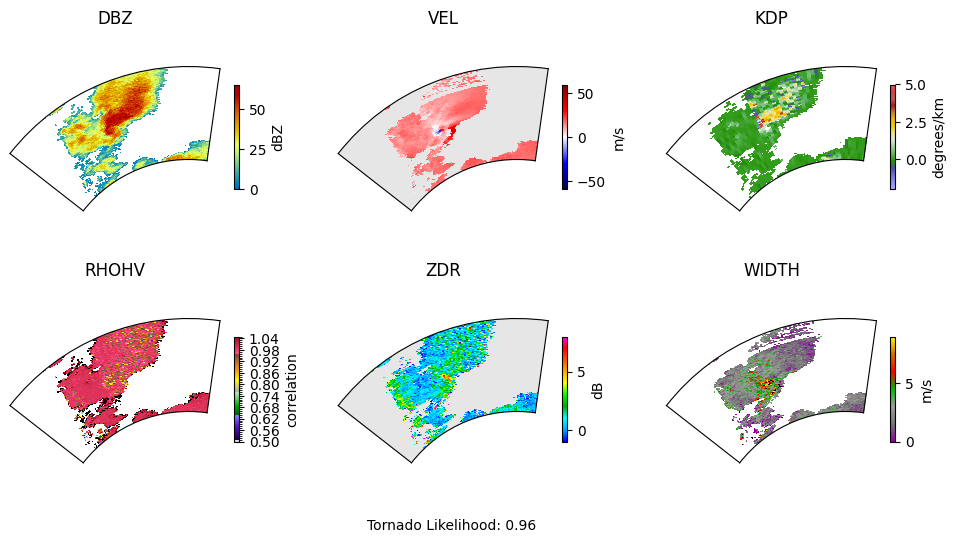

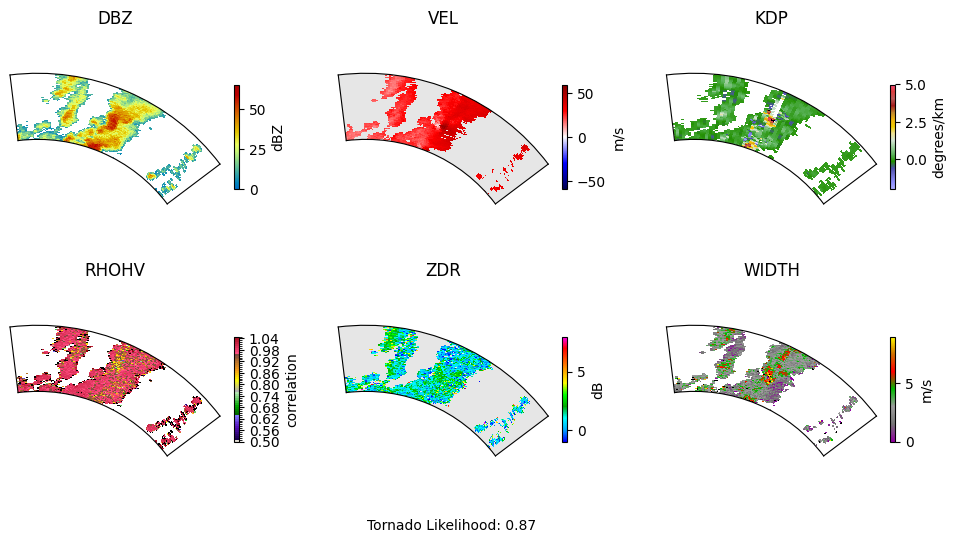

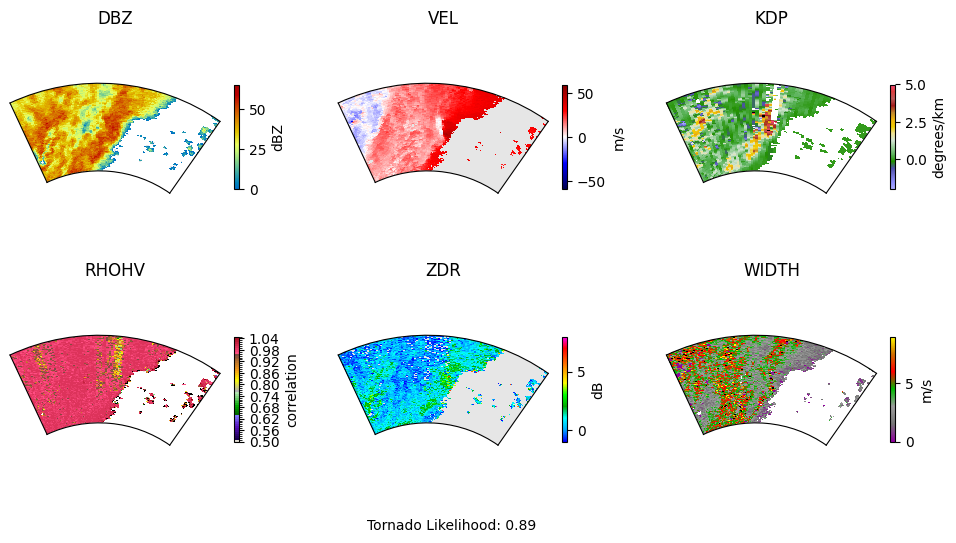

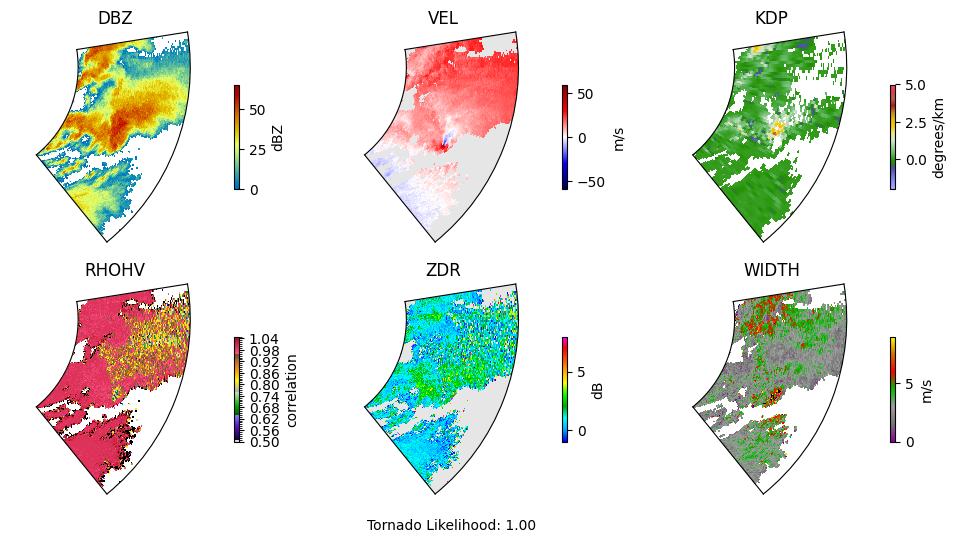

In [6]:
# Visualize samples along with model likelihood
from tornet.display.display import plot_radar

vars_to_plot=['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH']

for didx in range(4):
    fig = plt.figure(figsize=(12,6),edgecolor='k')
    plot_radar(x,
               fig=fig,
               channels=vars_to_plot,
               include_cbar=True,
               time_idx=didx, 
               n_rows=2, n_cols=3)

    # Add a caption (optional)
    fig.text(.5, .05, 'Tornado Likelihood: %.2f' % p[didx,0] , ha='center');
    

## Run model on non-tornado samples

In [7]:
# Load full catalog and select EF 3+ tornadoes
data_root=os.environ['TORNET_ROOT']

catalog_path = os.path.join(data_root,'catalog.csv')
if not os.path.exists(catalog_path):
    raise RuntimeError('Unable to find catalog.csv at '+data_root)
        
catalog = pd.read_csv(catalog_path,parse_dates=['start_time','end_time'])
catalog=catalog[catalog.ef_number==-1] # non tornadoes only

ds_test = KerasDataLoader(data_root=data_root,
                         data_type='test',
                         random_state=1234,
                         catalog=catalog,
                         batch_size = 4, 
                         workers = 4,
                         use_multiprocessing = True)

In [8]:
# grab a batch and run through model
for x,y in ds_test:
    xin = {k:x[k] for k in cnn.input} # limit to only expected inputs
    p=cnn.predict(xin,verbose=0) # this outputs a logit
    p = 1/(1+np.exp(-p)) # apply sigmoid to map to [0,1]
    break


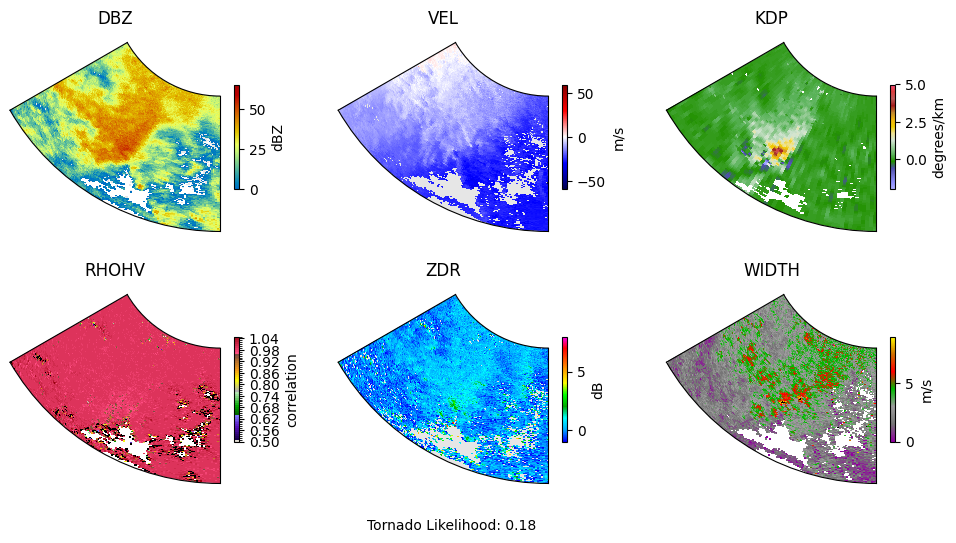

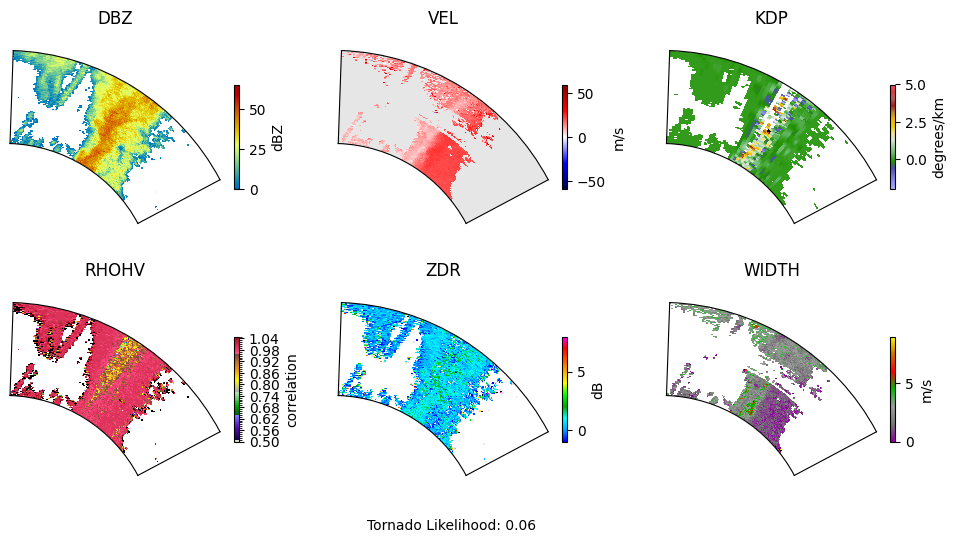

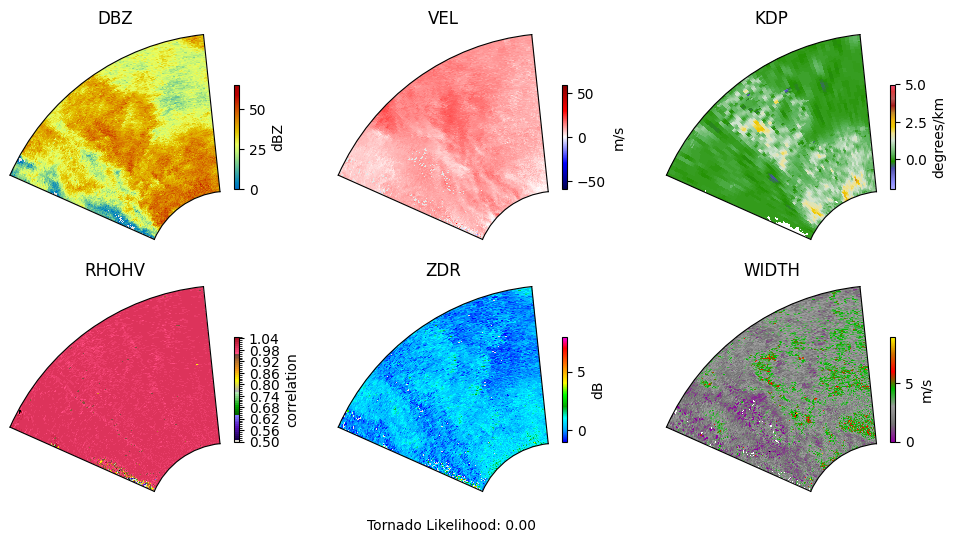

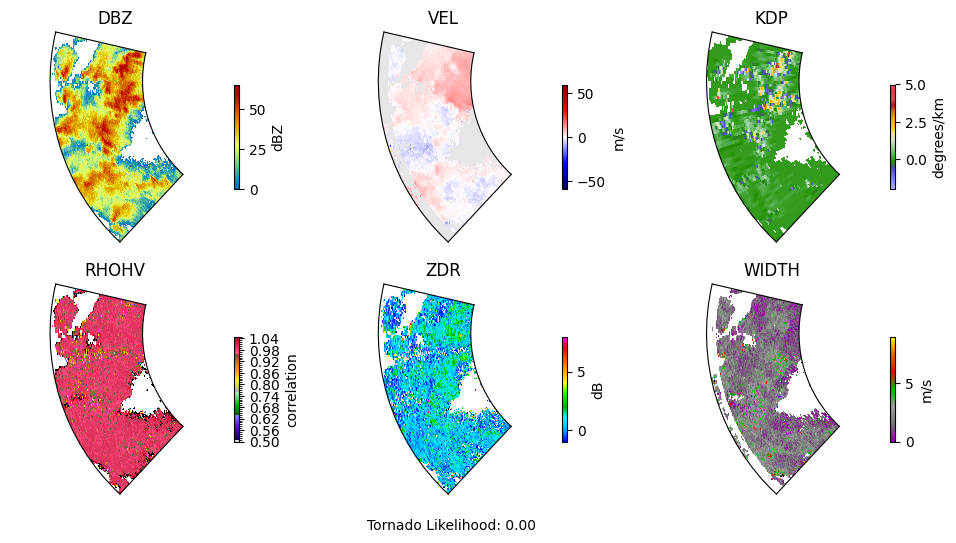

In [9]:
# Visualize samples along with model likelihood
from tornet.display.display import plot_radar

vars_to_plot=['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH']

for didx in range(4):
    fig = plt.figure(figsize=(12,6),edgecolor='k')
    plot_radar(x,
               fig=fig,
               channels=vars_to_plot,
               include_cbar=True,
               time_idx=didx, 
               n_rows=2, n_cols=3)

    # Add a caption (optional)
    fig.text(.5, .05, 'Tornado Likelihood: %.2f' % p[didx,0] , ha='center');
    